# Pengerjaan Tugas Deep Learning Week 5 Menggunakan Tensorflow

# Tahap Persiapan

## 1. Instalasi Modul yang diperlukan

In [1]:
# !pip install numpy pandas matplotlib scikit-learn tensorflow tensorflow-datasets
%pip install numpy pandas matplotlib scikit-learn tensorflow tensorflow-datasets

Note: you may need to restart the kernel to use updated packages.


## 2. Mengimpor Library yang Dibutuhkan

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io
import re
from collections import Counter
import time

# Memeriksa ketersediaan GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## 3. Mendefinisikan Parameter dan Pre-processing Dataset

Dataset shape: (23486, 11)
   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Int

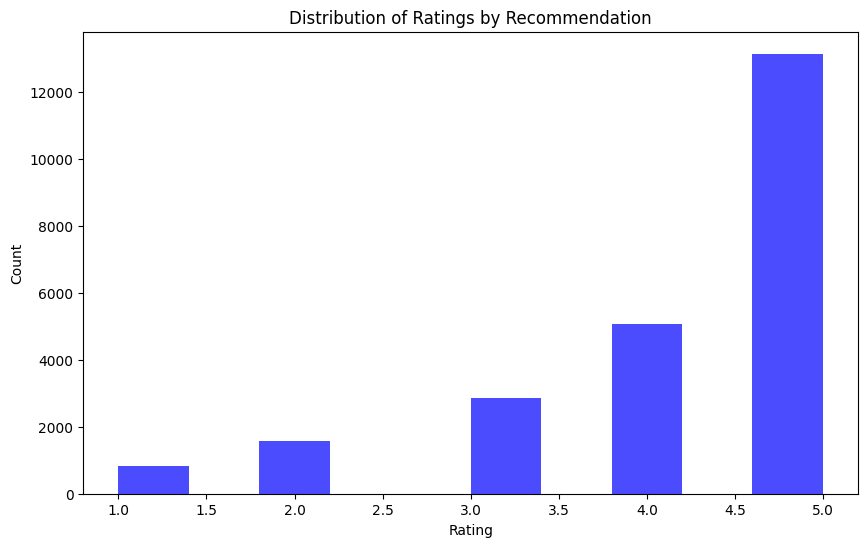

Found 15395 unique tokens
Shape of X_train: (18788, 100)
Shape of X_test: (4698, 100)


In [3]:
# Konstanta dan parameter
NUM_WORDS = 40000
MAXLEN = 100
BATCH_SIZE = 64
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
DROPOUT_RATE = 0.33
EPOCHS = 20
LEARNING_RATE = 0.001

# Baca dataset
df = pd.read_csv('../ReviewTokoBaju.csv')

# Data Exploration
print(f"Dataset shape: {df.shape}")
print(df.head())
print(df.info())

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Fill missing values in 'Review Text' and 'Title'
df['Review Text'] = df['Review Text'].fillna('')
df['Title'] = df['Title'].fillna('')

# Combine Title and Review Text for better features
df['Combined_Text'] = df['Title'] + ' ' + df['Review Text']

# Target variable: 'Recommended IND' (0 or 1)
print("\nDistribution of Recommended IND:")
print(df['Recommended IND'].value_counts())

# Check correlation between Rating and Recommended IND
print("\nCorrelation between Rating and Recommended IND:")
print(df[['Rating', 'Recommended IND']].corr())

# Plot distribution of ratings
plt.figure(figsize=(10, 6))
plt.hist(df['Rating'], bins=10, color='blue', alpha=0.7)
plt.title('Distribution of Ratings by Recommendation')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# TensorFlow tokenizer
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Combined_Text'])
sequences = tokenizer.texts_to_sequences(df['Combined_Text'])
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')

X = pad_sequences(sequences, maxlen=MAXLEN, padding='post', truncating='post')
y = df['Recommended IND'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

train_data = (X_train, y_train)
test_data = (X_test, y_test)


## 4. Menyiapkan Fungsi Pelatihan dan Validasi

In [4]:
# Fungsi untuk melatih model
def train_model(model, train_data, model_name):
    x_train, y_train = train_data
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=f'model_tensorflow_{model_name}.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    print(f"Memulai pelatihan model {model_name}...")
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        shuffle=True,
        callbacks=callbacks,
        verbose=1
    )
    
    end_time = time.time()
    training_time = end_time - start_time
    mins, secs = divmod(training_time, 60)
    print(f"Waktu pelatihan: {int(mins)}m {int(secs)}s")
    
    return history

## 5. Menyiapkan Fungsi Evaluasi

In [5]:
# Fungsi untuk evaluasi model
def evaluate_model(model, test_data, model_name):
    x_test, y_test = test_data
    
    # Prediksi
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Menghitung ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # Print hasil evaluasi
    print(f"\nEvaluasi Model {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred_prob': y_pred_prob,
        'y_pred': y_pred,
        'y_test': y_test
    }

## 6. Menyiapkan Fungsi Visualisasi

In [6]:
# Fungsi untuk membuat visualisasi training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Valid Loss')
    plt.title(f'{model_name} - Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
    plt.title(f'{model_name} - Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'training_history_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat ROC curve
def plot_roc_curve(results_dict):
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results_dict.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["auc"]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve_comparison_tensorflow.png')
    plt.show()

# Fungsi untuk membuat bar chart perbandingan metrik
def plot_metrics_comparison(results_dict):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    models = list(results_dict.keys())
    
    values = {metric: [results_dict[model][metric] for model in models] for metric in metrics}
    
    plt.figure(figsize=(12, 8))
    bar_width = 0.15
    index = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[metric], bar_width, 
                label=metric.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Metrics Comparison')
    plt.xticks(index + bar_width * 2, models)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('metrics_comparison_tensorflow.png')
    plt.show()


# A. RNN dengan Tensorflow

## 1. Menyusun Model RNN


In [7]:
# Fungsi untuk membuat model RNN kompleks
def build_rnn_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),
        
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        SimpleRNN(HIDDEN_DIM // 2, return_sequences=False),
        Dropout(DROPOUT_RATE),
        
        Dense(HIDDEN_DIM // 4, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_rnn = build_rnn_model()

## 2. Melatih Model

In [8]:
# Menyusun model
model_rnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model RNN
print("Melatih model RNN...")
history_rnn = train_model(model_rnn, train_data, 'rnn')

Melatih model RNN...
Memulai pelatihan model rnn...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7896 - loss: 0.5151 - val_accuracy: 0.8199 - val_loss: 0.4743
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8271 - loss: 0.4801 - val_accuracy: 0.8199 - val_loss: 0.4734
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8165 - loss: 0.4884 - val_accuracy: 0.8199 - val_loss: 0.4719
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8224 - loss: 0.4800 - val_accuracy: 0.8199 - val_loss: 0.4732
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8272 - loss: 0.4682 - val_accuracy: 0.8199 - val_loss: 0.4708
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8219 - loss: 0.4762 - val_accuracy: 0.8199 - val_loss: 0.4711
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8262 - loss: 0.4711 - val_accuracy: 0.8199 - val_loss: 0.4711
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28

## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [9]:
# Evaluasi model RNN
result_rnn = evaluate_model(model_rnn, test_data, 'rnn')

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Evaluasi Model rnn:
Accuracy: 0.8189
Precision: 0.8189
Recall: 1.0000
F1 Score: 0.9004
AUC: 0.5278


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

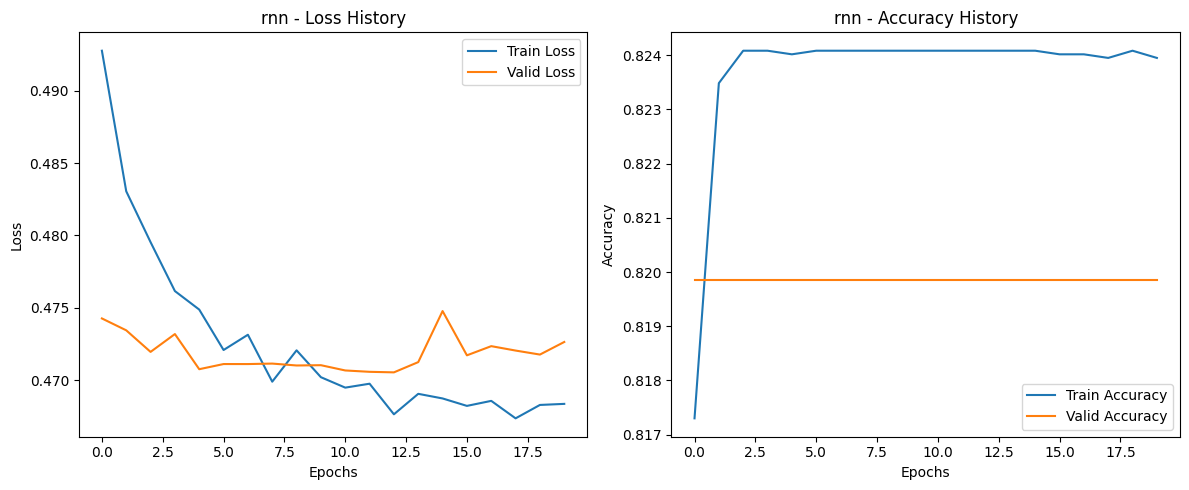

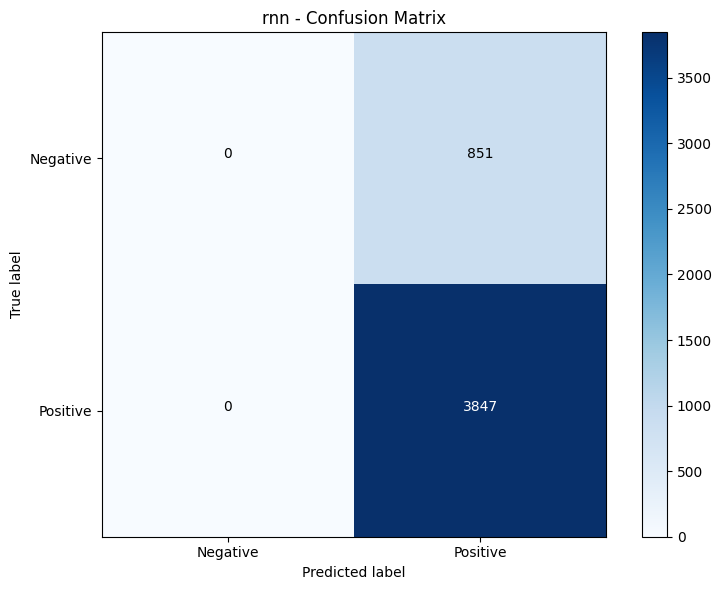

In [10]:
# Plotting hasil pelatihan
plot_training_history(history_rnn, "rnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_rnn['y_pred'], "rnn")

## 5. Menyimpan Model

In [11]:
# Menyimpan model
#model_rnn.save('model_tensorflow_rnn.keras')
#print("Model RNN disimpan sebagai 'model_rnn.keras'")

# B. LSTM dengan Tensorflow

## 1. Menyusun Model LSTM


In [12]:
# Fungsi untuk membuat model LSTM kompleks
def build_lstm_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),

        LSTM(HIDDEN_DIM, return_sequences=True),
        LSTM(HIDDEN_DIM // 2, return_sequences=False),
        Dropout(DROPOUT_RATE),

        Dense(HIDDEN_DIM // 4, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_lstm = build_lstm_model()

## 2. Melatih Model

In [13]:
# Menyusun model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model LSTM
print("Melatih model LSTM...")
history_lstm = train_model(model_lstm, train_data, 'lstm')

Melatih model LSTM...
Memulai pelatihan model lstm...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.8200 - loss: 0.4986 - val_accuracy: 0.8199 - val_loss: 0.4716
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.8226 - loss: 0.4773 - val_accuracy: 0.8180 - val_loss: 0.4585
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.8247 - loss: 0.4626 - val_accuracy: 0.8385 - val_loss: 0.4411
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.8353 - loss: 0.3803 - val_accuracy: 0.8547 - val_loss: 0.3838
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.8570 - loss: 0.3326 - val_accuracy: 0.8505 - val_loss: 0.3157
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.8769 - loss: 0.2768 - val_accuracy: 0.8318 - val_loss: 0.3440
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.9007 - loss: 0.2476 - val_accuracy: 0.8888 - val_loss: 0.2640
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━

## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [14]:
# Evaluasi model LSTM
result_lstm = evaluate_model(model_lstm, test_data, 'lstm')

147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Evaluasi Model lstm:
Accuracy: 0.8972
Precision: 0.9201
Recall: 0.9576
F1 Score: 0.9385
AUC: 0.9299


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

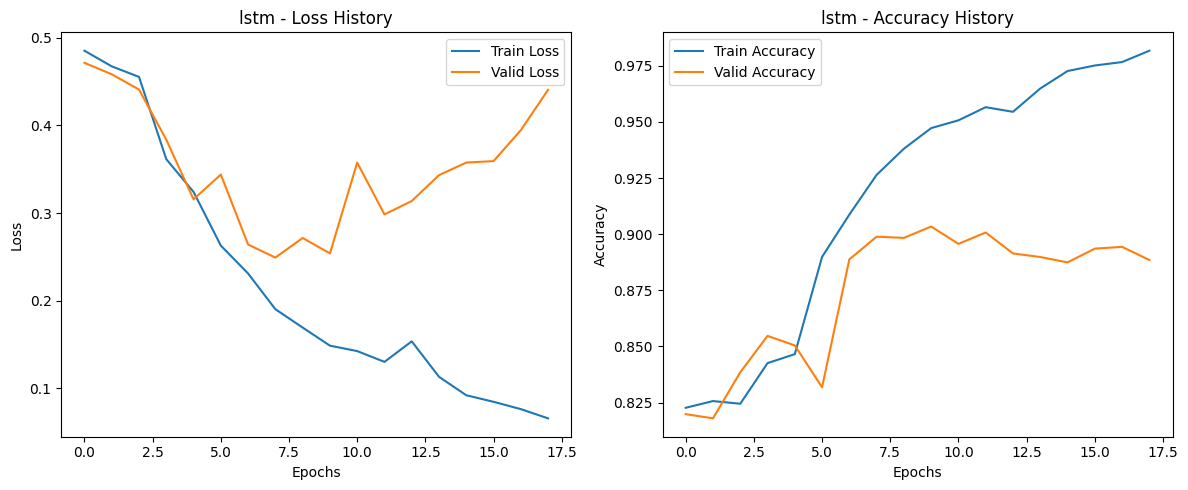

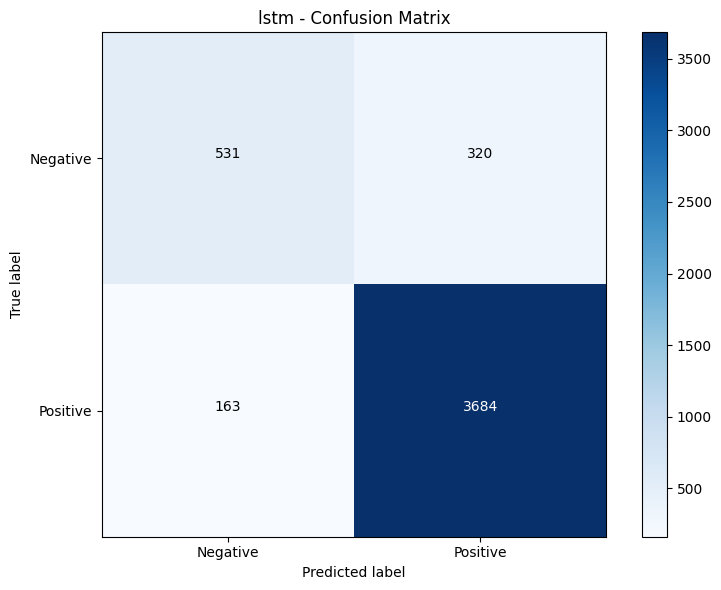

In [15]:
# Plotting hasil pelatihan
plot_training_history(history_lstm, "lstm")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_lstm['y_pred'], "lstm")

## 5. Menyimpan Model

In [16]:
# Menyimpan model
#model_lstm.save('model_tensorflow_lstm.keras')
#print("Model LSTM disimpan sebagai 'model_tensorflow_lstm.keras'")

# C. GRU dengan Tensorflow

## 1. Menyusun Model GRU


In [17]:
# Fungsi untuk membuat model GRU kompleks
def build_gru_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),
        
        GRU(HIDDEN_DIM, return_sequences=True),
        GRU(HIDDEN_DIM // 2, return_sequences=False),
        Dropout(DROPOUT_RATE),

        Dense(HIDDEN_DIM // 4, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_gru = build_gru_model()

## 2. Melatih Model

In [18]:
# Menyusun model
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model GRU
print("Melatih model gru...")
history_gru = train_model(model_gru, train_data, 'gru')

Melatih model gru...
Memulai pelatihan model gru...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8097 - loss: 0.5093 - val_accuracy: 0.8199 - val_loss: 0.4825
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.8206 - loss: 0.4767 - val_accuracy: 0.8188 - val_loss: 0.4617
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.8319 - loss: 0.4497 - val_accuracy: 0.9023 - val_loss: 0.2514
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.9174 - loss: 0.2096 - val_accuracy: 0.8968 - val_loss: 0.2448
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.9451 - loss: 0.1488 - val_accuracy: 0.9117 - val_loss: 0.2381
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.9667 - loss: 0.1009 - val_accuracy: 0.8999 - val_loss: 0.3151
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.9766 - loss: 0.0746 - val_accuracy: 0.8954 - val_loss: 0.3616
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━

## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [19]:
# Evaluasi model GRU
print("Evaluasi model GRU...")
result_gru = evaluate_model(model_gru, test_data, 'gru')

Evaluasi model GRU...
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Evaluasi Model gru:
Accuracy: 0.9053
Precision: 0.9432
Recall: 0.9410
F1 Score: 0.9421
AUC: 0.9436


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

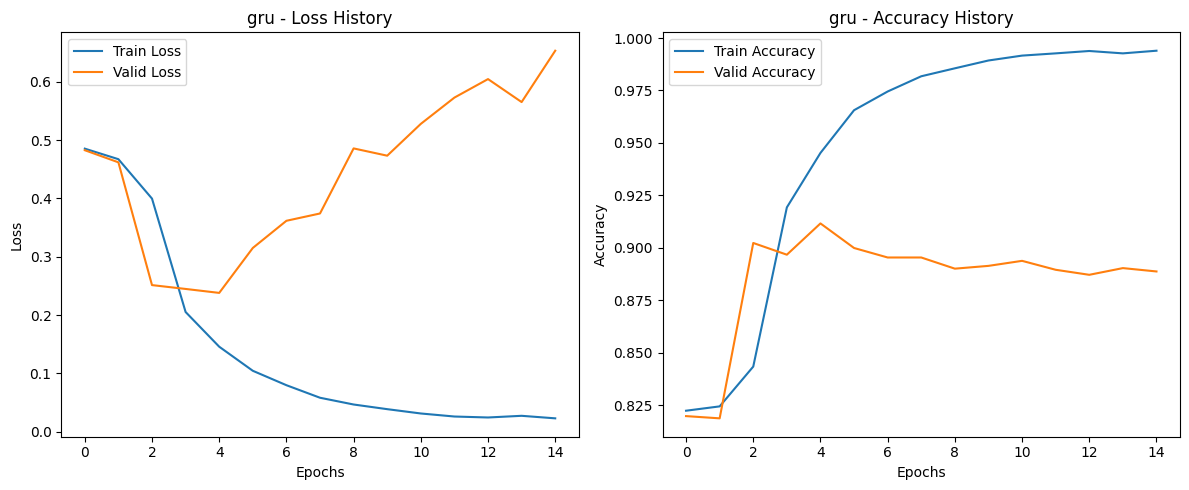

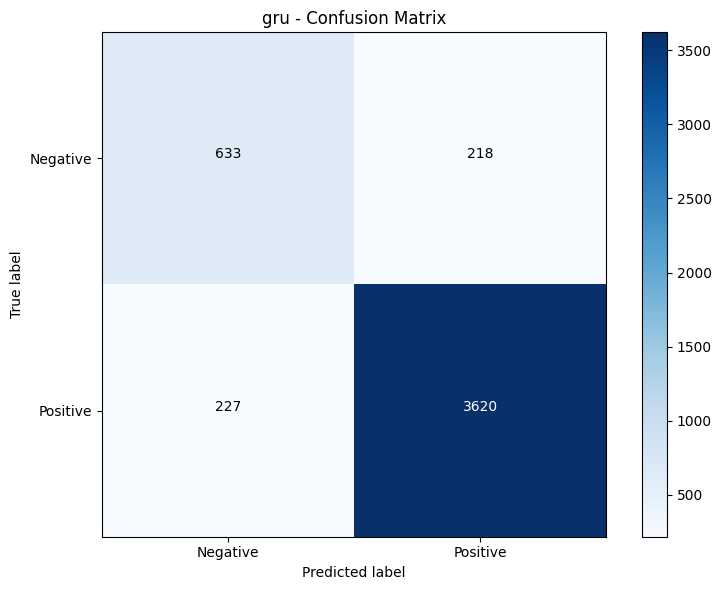

In [20]:
# Plotting hasil pelatihan
plot_training_history(history_gru, "gru")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_gru['y_pred'], "gru")

## 5. Menyimpan Model

In [21]:
# Menyimpan model
#model_gru.save('model_tensorflow_gru.keras')
#print("Model GRU disimpan sebagai 'model_tenosrflow_gru.keras'")

# Perbandingan antara model

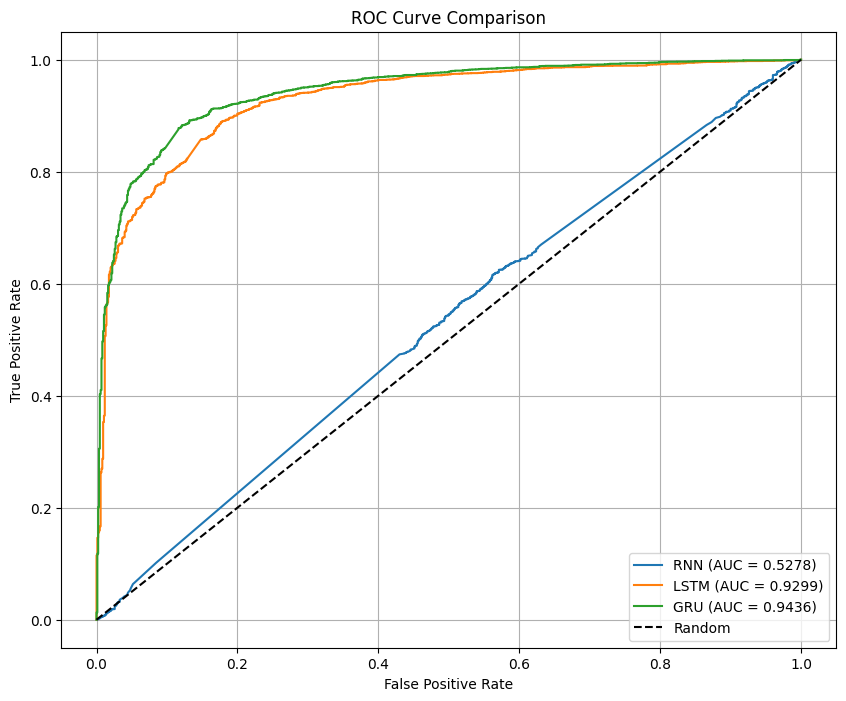

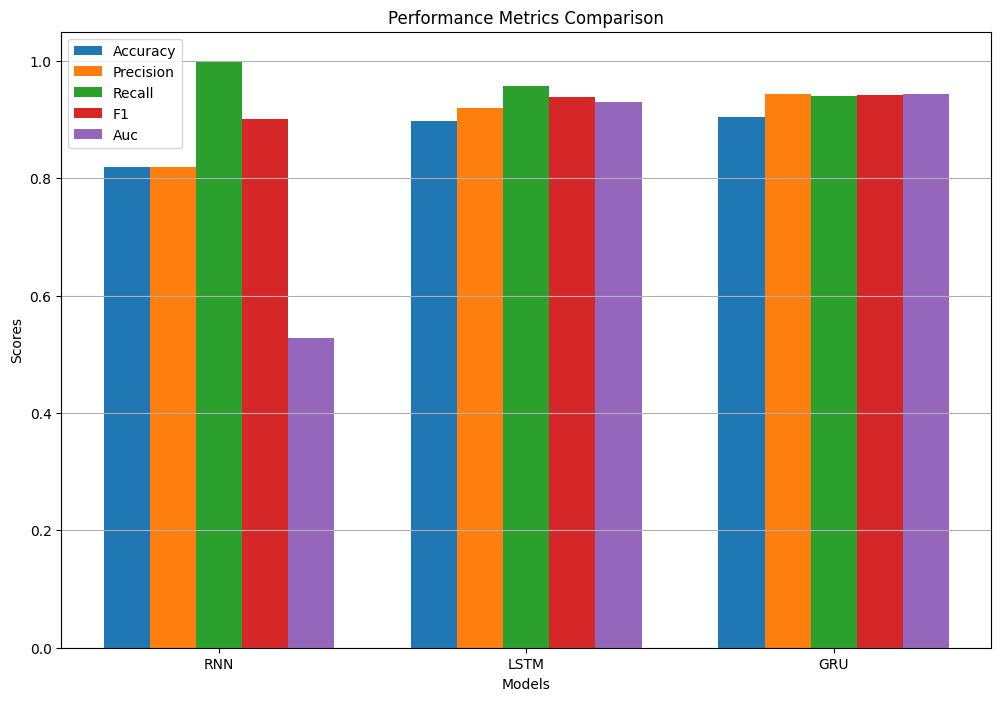

In [22]:
# Menghitung perbandingan untuk semua model
results_dict = {
    'RNN': result_rnn,
    'LSTM': result_lstm,
    'GRU': result_gru
}

# Plotting ROC curve
plot_roc_curve(results_dict)
# Plotting perbandingan metrik
plot_metrics_comparison(results_dict)